In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdmolops, AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys


from scipy.stats import pearsonr


# sklearn ML models
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import  LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

from sklearn.model_selection import KFold

import joblib

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'

# pip install shap
import shap

/Users/liugrp_m/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# exp gap

In [2]:
df = pd.read_csv('../01-database-preprocessing-1203dp-to-1115dp/raw/atom_number_wH_sort_1115-backbone-correction-newSMILES.csv')
df

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No,HOMO(eV),LUMO(eV)
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10,-5.20,-3.27
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123,-4.90,-3.08
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126,-5.34,-3.58
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122,-5.15,-3.23
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122,-5.11,-3.22
...,...,...,...,...,...,...,...
1110,BTT-NTz,1.68,CCCCCCCCCCCCc1cc(C)sc1-c1cc2c3sc(C(CCCCCCCC)CC...,Cc1cc(C)c(s1)-c1cc2c3sc(C)cc3c3cc(sc3c2s1)-c1s...,S115,-5.41,-3.73
1111,PIDTI-BT,1.65,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1cc2n(C)c3cc4-c5cc6c(cc5C(c4cc3c2s1)(c1ccccc...,S441,-5.30,-3.65
1112,PIDTI-DTBT,1.66,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1ccc(s1)-c1ccc(-c2ccc(s2)-c2cc3n(C)c4cc5-c6c...,S441,-5.26,-3.60
1113,poly(DPP4T-alt-TBP),1.52,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)C2=C(c3ccc(-c...,CN1C(=O)C2=C(N(C)C(=O)C2=C1c1ccc(C)s1)c1ccc(s1...,S464,-5.42,-3.90


In [3]:
df_exp = df['bandgap(eV)']
df_exp

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1110    1.68
1111    1.65
1112    1.66
1113    1.52
1114    1.73
Name: bandgap(eV), Length: 1115, dtype: float64

# DFT gap

In [4]:
df = pd.read_csv('../03-DFT-polymer/DFT/scf-6-31gs.csv')
scf = df[['HOMO-LUMO(eV)']]
scf.columns = ['HOMO-LUMO gap']
scf

,HOMO-LUMO gap
0,2.78726
1,2.72032
2,3.19979
3,2.69964
4,2.66372
...,...
1110,1.93038
1111,1.93065
1112,2.04439
1113,1.94561


# RDKit-209

In [5]:
rdkit_feature = pd.read_csv('../04-ML-baseline-model/monomer-1115dp-RDKit209.csv')

features = pd.read_csv('../04-ML-baseline-model/rdkit_feature_list.csv')
rdkit_feature_list = features.columns
rdkit_feature_list

df_rdkit_screen = rdkit_feature[rdkit_feature_list]
df_rdkit_screen

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,FpDensityMorgan1,BalabanJ,PEOE_VSA1,PEOE_VSA11,PEOE_VSA12,...,NumAromaticHeterocycles,NumHAcceptors,fr_C_O,fr_aniline,fr_bicyclic,fr_halogen,fr_imide,fr_ketone_Topliss,fr_oxazole,fr_pyridine
0,2.353121,1.287870,1.287870,0.608740,196.359,1.153846,2.318302,0.000000,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
1,2.323896,1.288704,1.288704,0.485488,228.426,1.214286,2.209145,0.000000,0.0,0.0,...,1,2,0,0,0,0,0,0,0,0
2,2.313310,1.230210,1.230210,0.463323,300.511,0.857143,1.833656,0.000000,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
3,12.542211,0.175600,-0.175600,0.510163,350.549,1.173913,2.074957,4.736863,0.0,0.0,...,2,4,1,0,0,0,0,0,0,0
4,12.817589,0.184059,-0.184059,0.318494,432.676,0.964286,1.756705,4.736863,0.0,0.0,...,3,5,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,5.448759,0.613257,0.613257,0.035659,2093.634,0.211268,0.950806,0.000000,0.0,0.0,...,9,13,0,0,11,0,0,0,0,0
1111,6.964899,0.506884,-0.861916,0.035381,2097.349,0.245033,0.981006,28.081651,0.0,0.0,...,5,11,0,0,13,0,0,0,0,0
1112,7.004105,0.497358,-0.874785,0.035381,2261.603,0.223602,0.904925,28.081651,0.0,0.0,...,7,13,0,0,13,0,0,0,0,0
1113,17.056452,0.015571,0.015571,0.035580,2289.808,0.162500,0.900316,19.599639,0.0,0.0,...,6,10,4,0,2,0,0,0,0,0


# MorganFP-1024

In [6]:
Morgan_fingerprints = pd.read_csv('../04-ML-baseline-model/monomer-1115dp-MorganFP-1024.csv')
Morgan_fingerprints

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_1014,f_1015,f_1016,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1111,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1112,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# MACCS-167

In [7]:
MACCS_fingerprints = pd.read_csv('../04-ML-baseline-model/monomer-1115dp-maccs-167.csv')
MACCS_fingerprints

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,m_157,m_158,m_159,m_160,m_161,m_162,m_163,m_164,m_165,m_166
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,0
1111,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1112,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1113,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0


# drop sp3-N polymers + donor-692

In [8]:
sp3_N_list = [  24,   44,  191,  201,  206,  209,  251,  317,  318,  332,  374,
             381,  388,  454,  913,  931,  936, 1006]
drop_list = sp3_N_list+[691]
print('Total data points: ', 1115-len(drop_list))

Total data points:  1096


In [9]:
df_dft = scf[~scf.index.isin(drop_list)].reset_index(drop=True)

df_rdkit_screen = df_rdkit_screen[~df_rdkit_screen.index.isin(drop_list)].reset_index(drop=True)

Morgan_fingerprints = Morgan_fingerprints[~Morgan_fingerprints.index.isin(drop_list)].reset_index(drop=True)

MACCS_fingerprints = MACCS_fingerprints[~MACCS_fingerprints.index.isin(drop_list)].reset_index(drop=True)

df_exp = df_exp[~df_exp.index.isin(drop_list)].reset_index(drop=True)

# ML regression

In [10]:
y = df_exp
y

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1091    1.68
1092    1.65
1093    1.66
1094    1.52
1095    1.73
Name: bandgap(eV), Length: 1096, dtype: float64

## a. features

In [11]:
# X = df_dft
X = pd.concat([df_rdkit_screen,df_dft], axis = 1)
# X = pd.concat([Morgan_fingerprints,df_dft], axis = 1)
# X = pd.concat([MACCS_fingerprints,df_dft], axis = 1)
# X = pd.concat([df_rdkit_screen, Morgan_fingerprints, df_dft], axis = 1)
# X = pd.concat([df_rdkit_screen, MACCS_fingerprints, df_dft], axis = 1)
# X = pd.concat([Morgan_fingerprints, MACCS_fingerprints, df_dft], axis = 1)
# X = pd.concat([df_rdkit_screen, Morgan_fingerprints, MACCS_fingerprints, df_dft], axis = 1)
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,FpDensityMorgan1,BalabanJ,PEOE_VSA1,PEOE_VSA11,PEOE_VSA12,...,NumHAcceptors,fr_C_O,fr_aniline,fr_bicyclic,fr_halogen,fr_imide,fr_ketone_Topliss,fr_oxazole,fr_pyridine,HOMO-LUMO gap
0,2.353121,1.287870,1.287870,0.608740,196.359,1.153846,2.318302,0.000000,0.0,0.0,...,1,0,0,0,0,0,0,0,0,2.78726
1,2.323896,1.288704,1.288704,0.485488,228.426,1.214286,2.209145,0.000000,0.0,0.0,...,2,0,0,0,0,0,0,0,0,2.72032
2,2.313310,1.230210,1.230210,0.463323,300.511,0.857143,1.833656,0.000000,0.0,0.0,...,1,0,0,0,0,0,0,0,0,3.19979
3,12.542211,0.175600,-0.175600,0.510163,350.549,1.173913,2.074957,4.736863,0.0,0.0,...,4,1,0,0,0,0,0,0,0,2.69964
4,12.817589,0.184059,-0.184059,0.318494,432.676,0.964286,1.756705,4.736863,0.0,0.0,...,5,1,0,0,0,0,0,0,0,2.66372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,5.448759,0.613257,0.613257,0.035659,2093.634,0.211268,0.950806,0.000000,0.0,0.0,...,13,0,0,11,0,0,0,0,0,1.93038
1092,6.964899,0.506884,-0.861916,0.035381,2097.349,0.245033,0.981006,28.081651,0.0,0.0,...,11,0,0,13,0,0,0,0,0,1.93065
1093,7.004105,0.497358,-0.874785,0.035381,2261.603,0.223602,0.904925,28.081651,0.0,0.0,...,13,0,0,13,0,0,0,0,0,2.04439
1094,17.056452,0.015571,0.015571,0.035580,2289.808,0.162500,0.900316,19.599639,0.0,0.0,...,10,4,0,2,0,0,0,0,0,1.94561


## c. model define

In [12]:
# model = HistGradientBoostingRegressor()
# lgbm = LGBMRegressor(force_row_wise = True)
# gbr = GradientBoostingRegressor()
# xgb = XGBRegressor()
# adaboost = AdaBoostRegressor()
# rf = RandomForestRegressor()

# SHAP analysis

### 1. train-test random split

In [25]:
def shap_plot(top_5_features, feature_importance, name):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    bars = plt.barh(top_5_features, feature_importance['Importance'].iloc[:5], color='#67a9cf')

    # 添加SHAP值标记
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center', fontsize=20)

    ax.tick_params(direction='in', width=2)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)

    for spine in ax.spines.values():
        spine.set_linewidth(2)

    plt.title(name, fontsize=30, pad=20)
    plt.xlabel('Mean (|SHAP Value|)', fontsize = 25, labelpad=12)
    xticks = [0, 0.05, 0.1, 0.15]
    plt.xticks(xticks,fontsize=20)
    plt.yticks(fontsize=16)
    plt.xlim(0,0.15)

    plt.gca().invert_yaxis()    
    plt.show()

In [26]:
models = {
    'HGBR': HistGradientBoostingRegressor(),
    'LGBM': LGBMRegressor(force_col_wise=True, verbose=-1),
    'GBR': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
#     'adaboost': AdaBoostRegressor(),
    'RF': RandomForestRegressor()
}

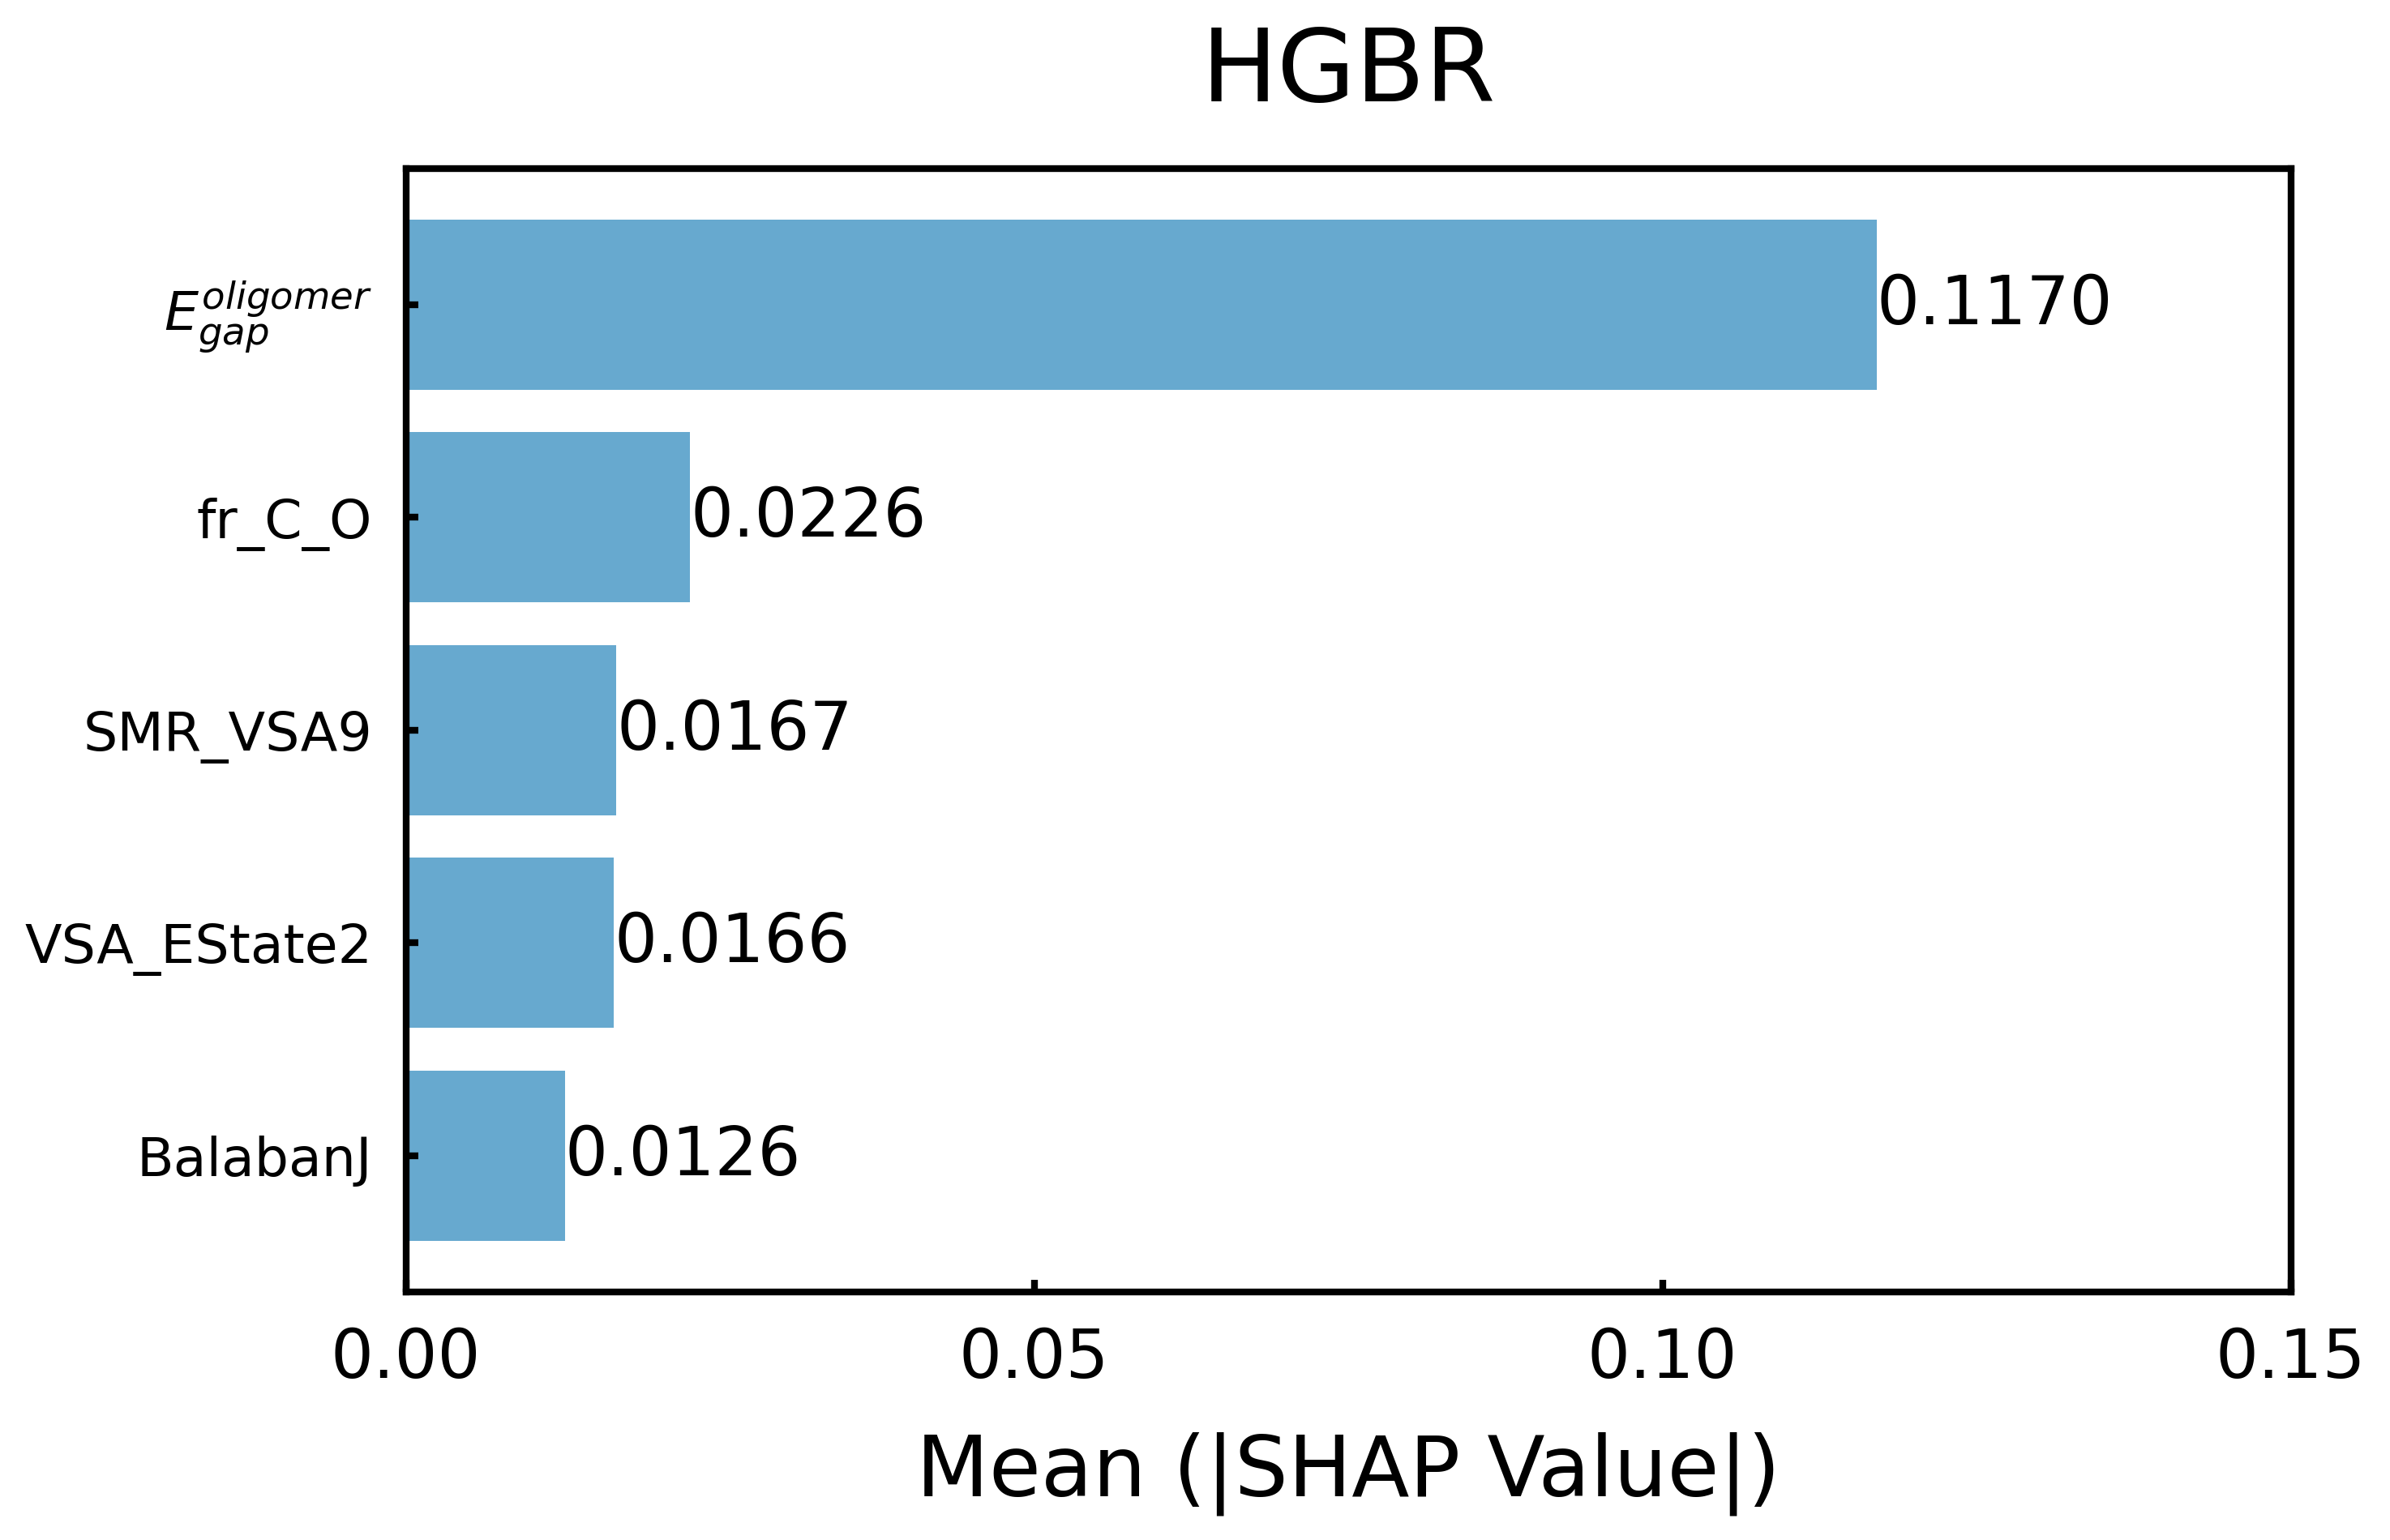

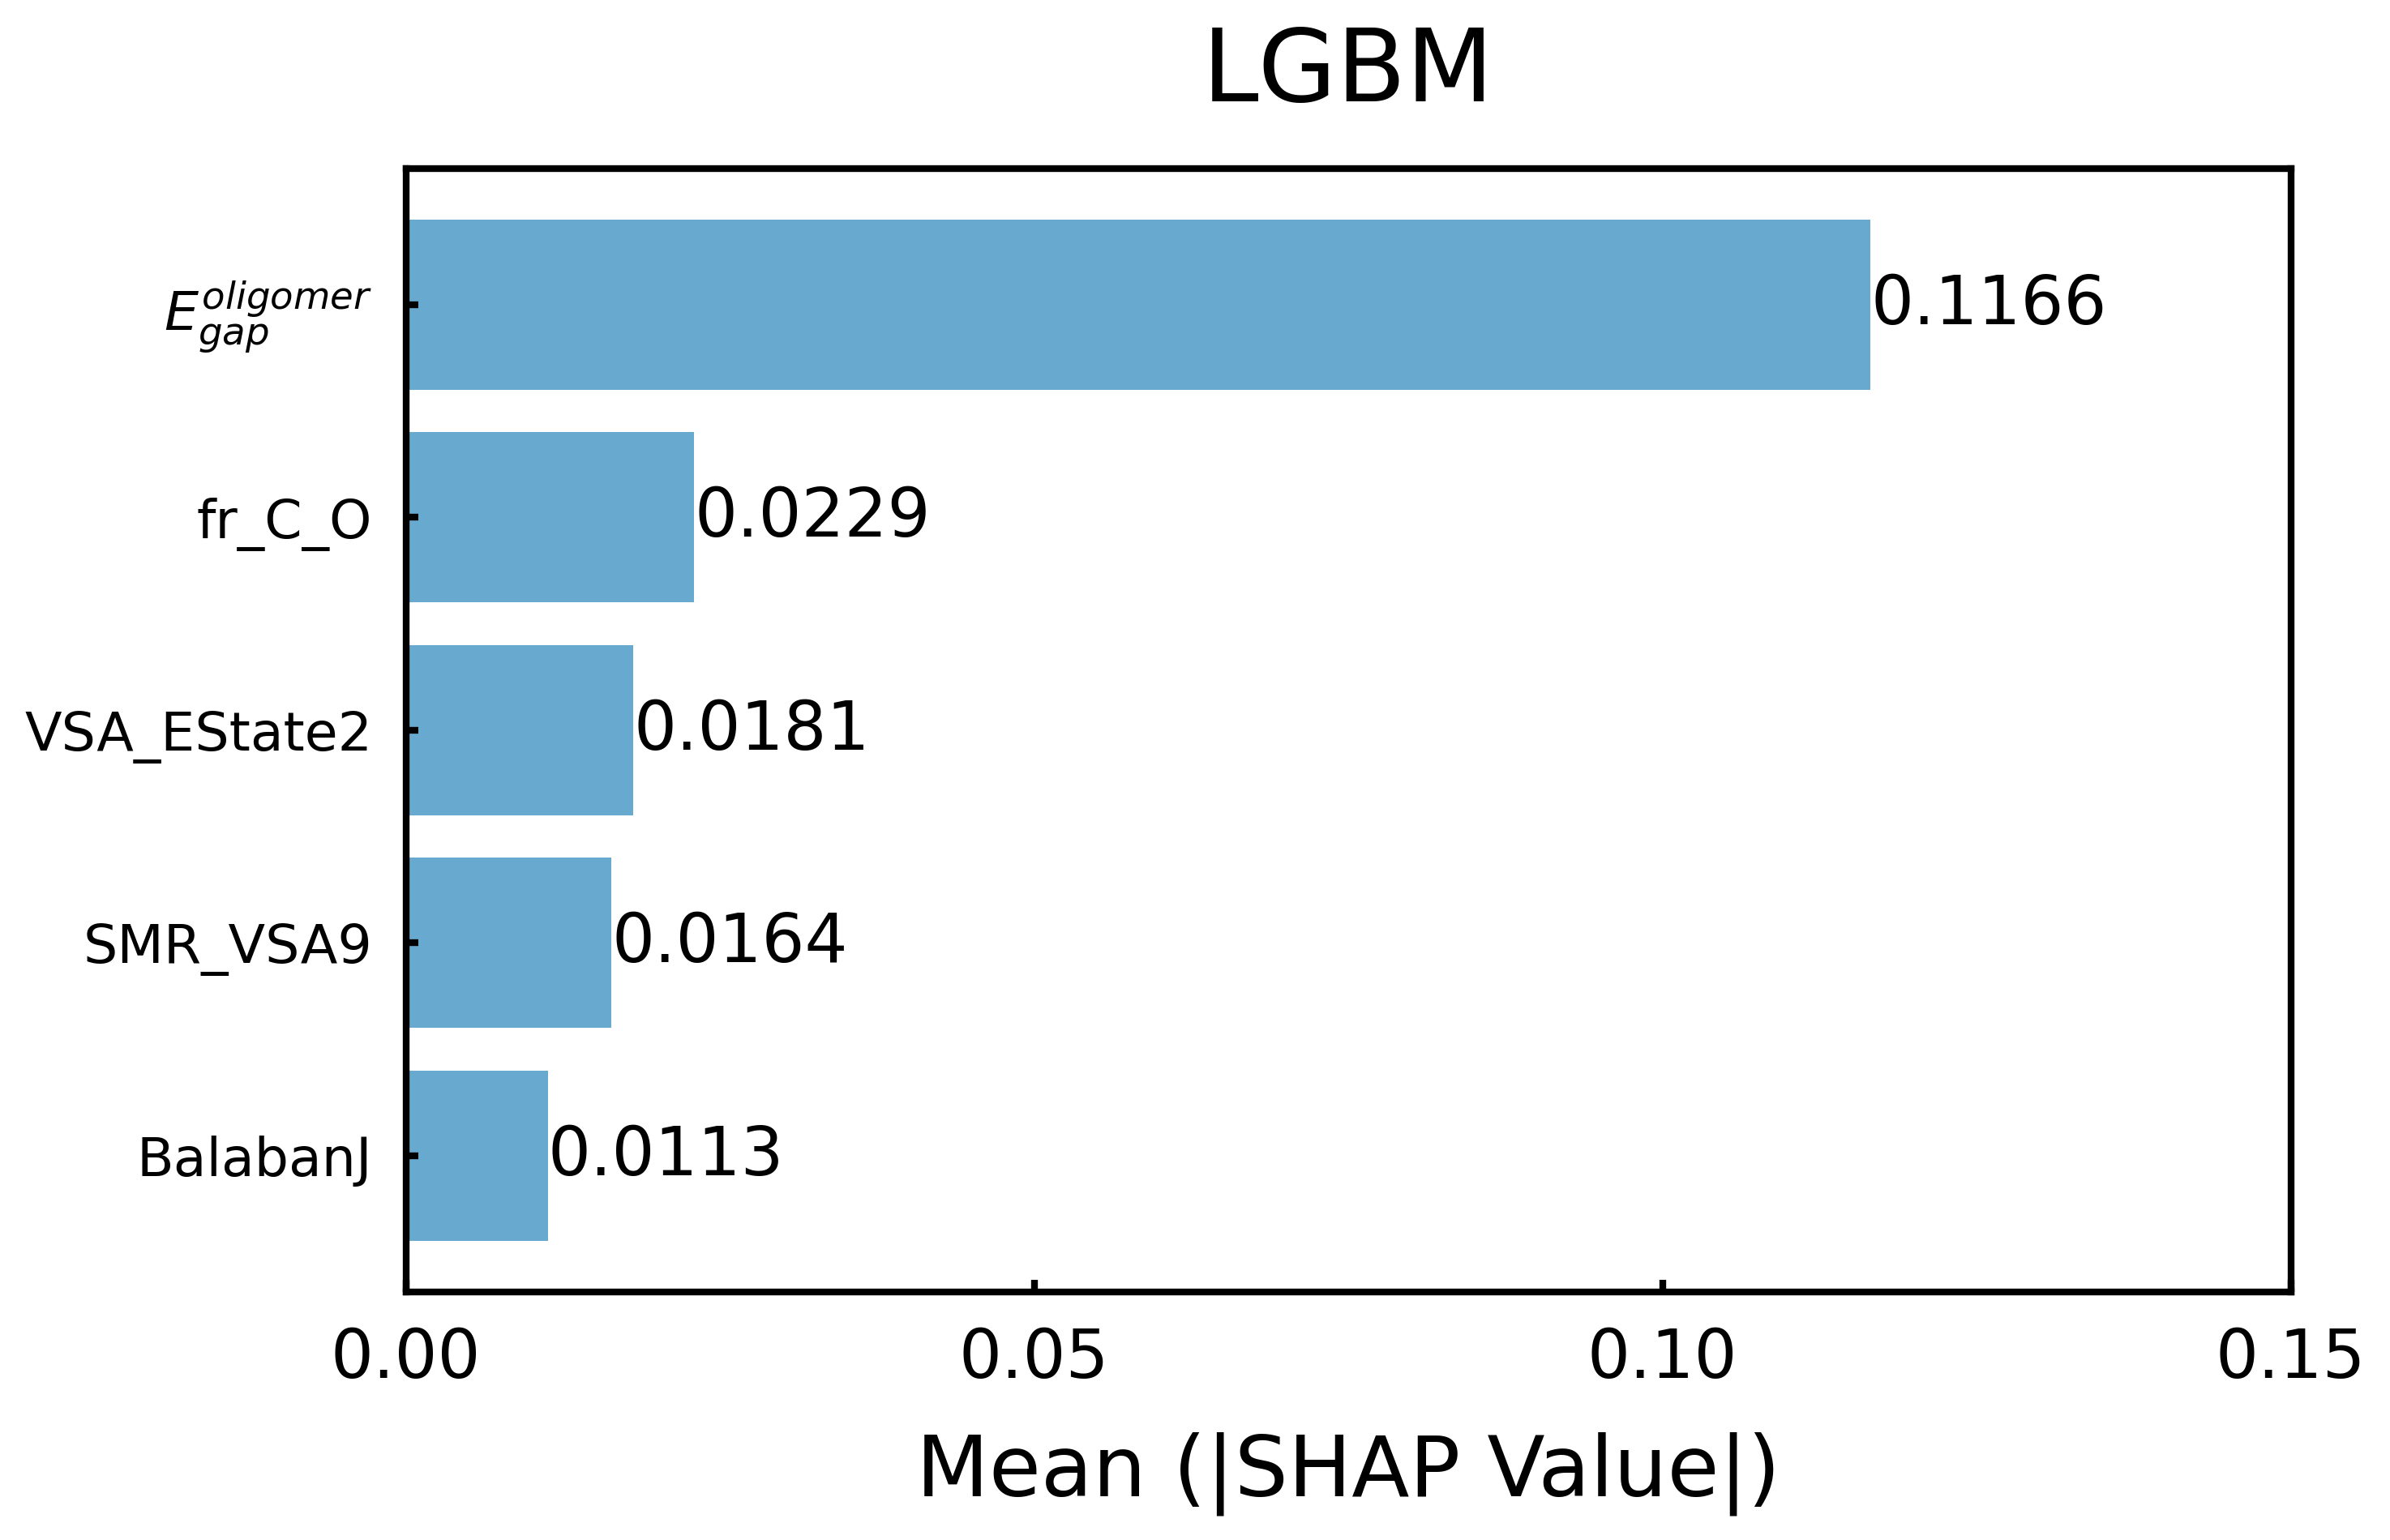

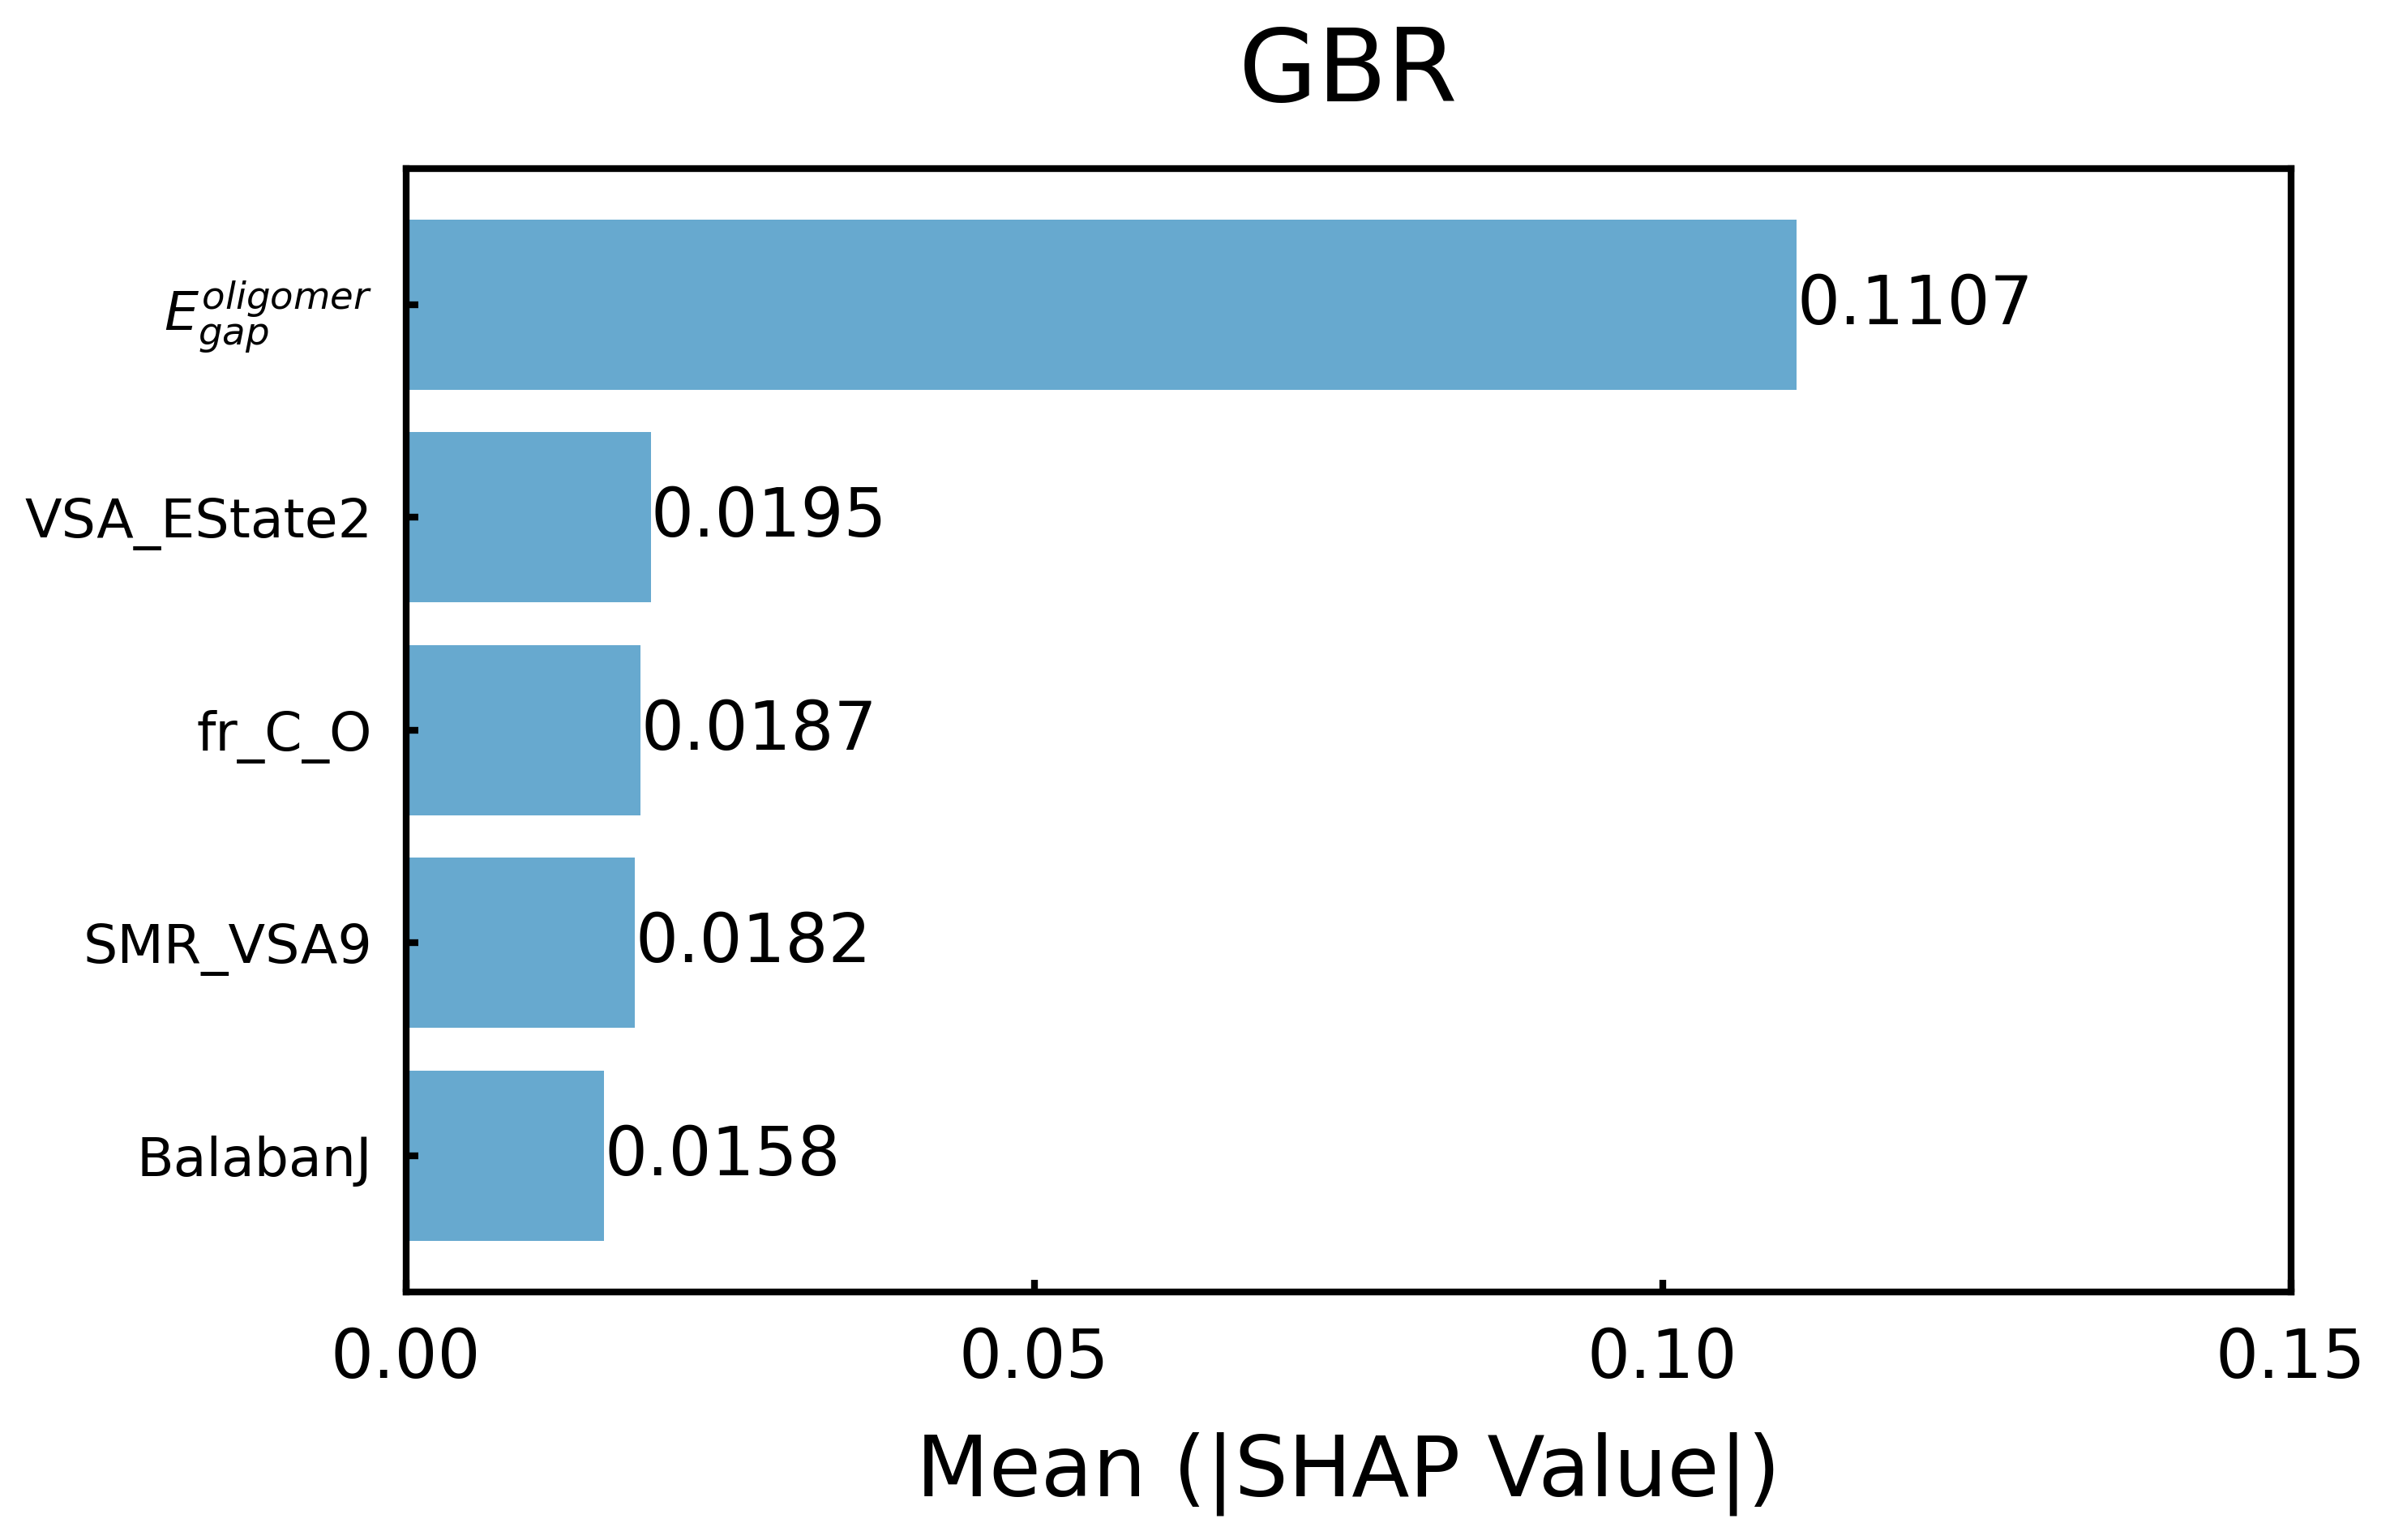

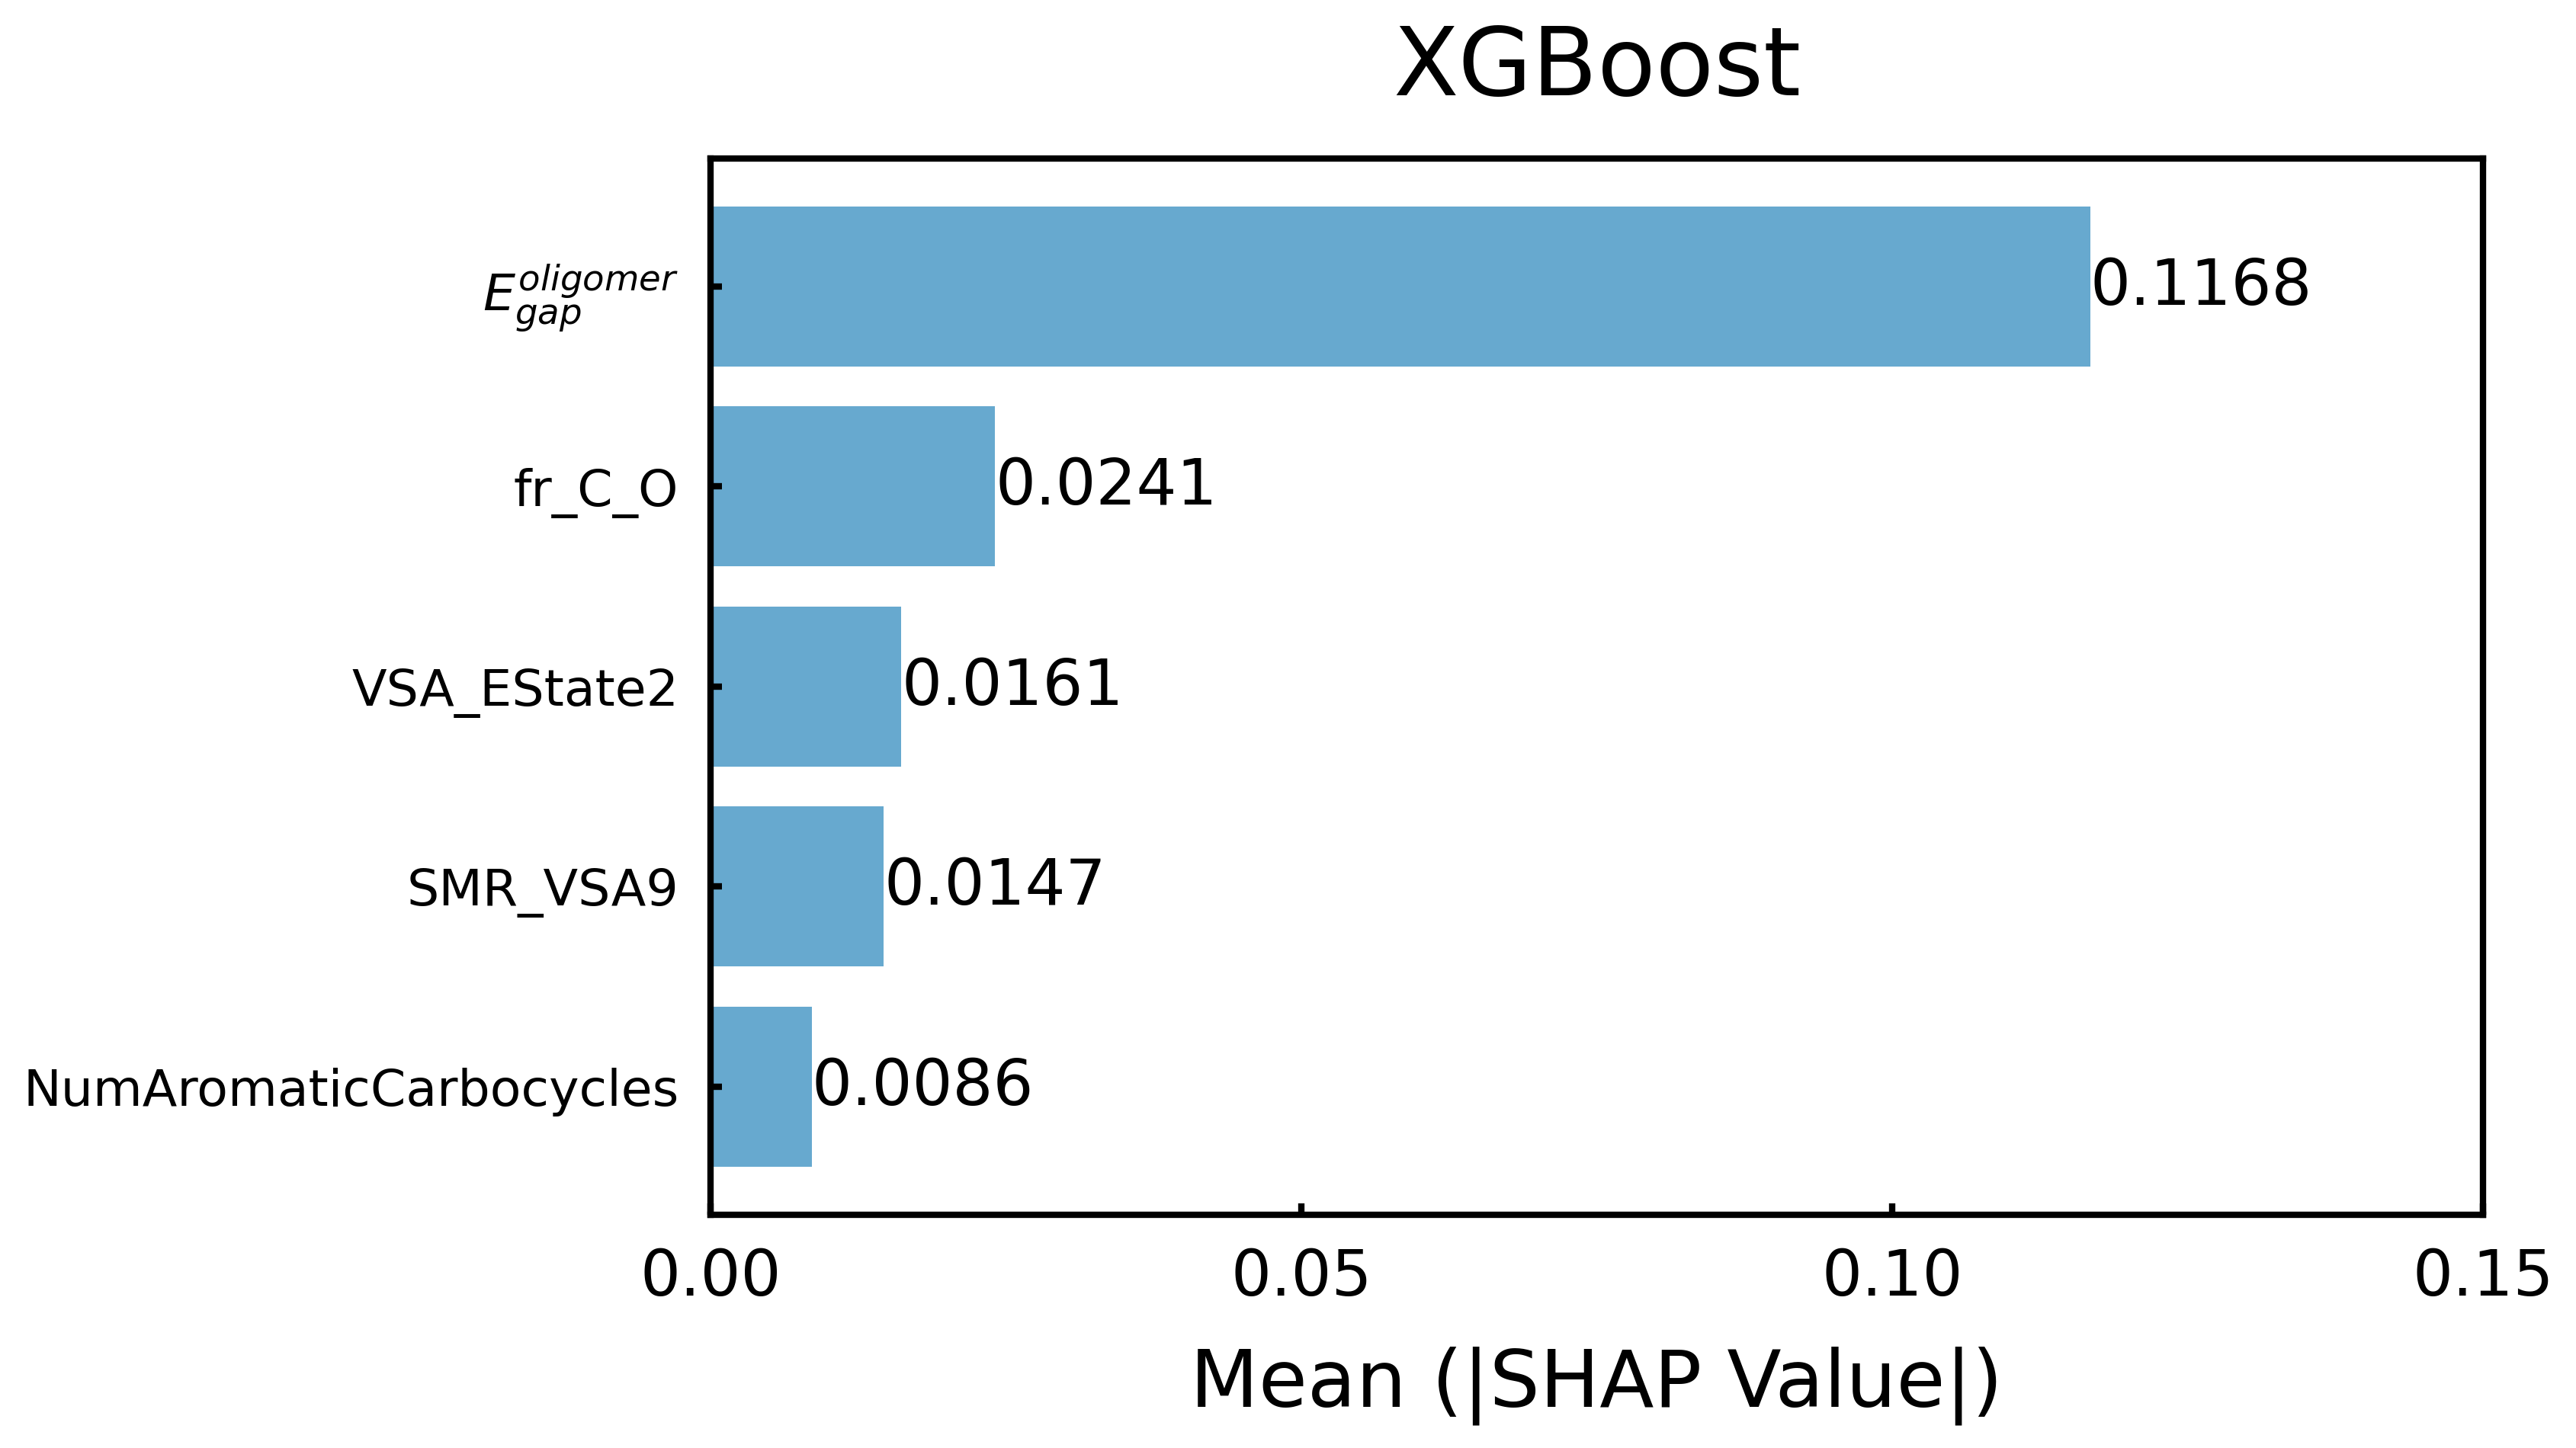

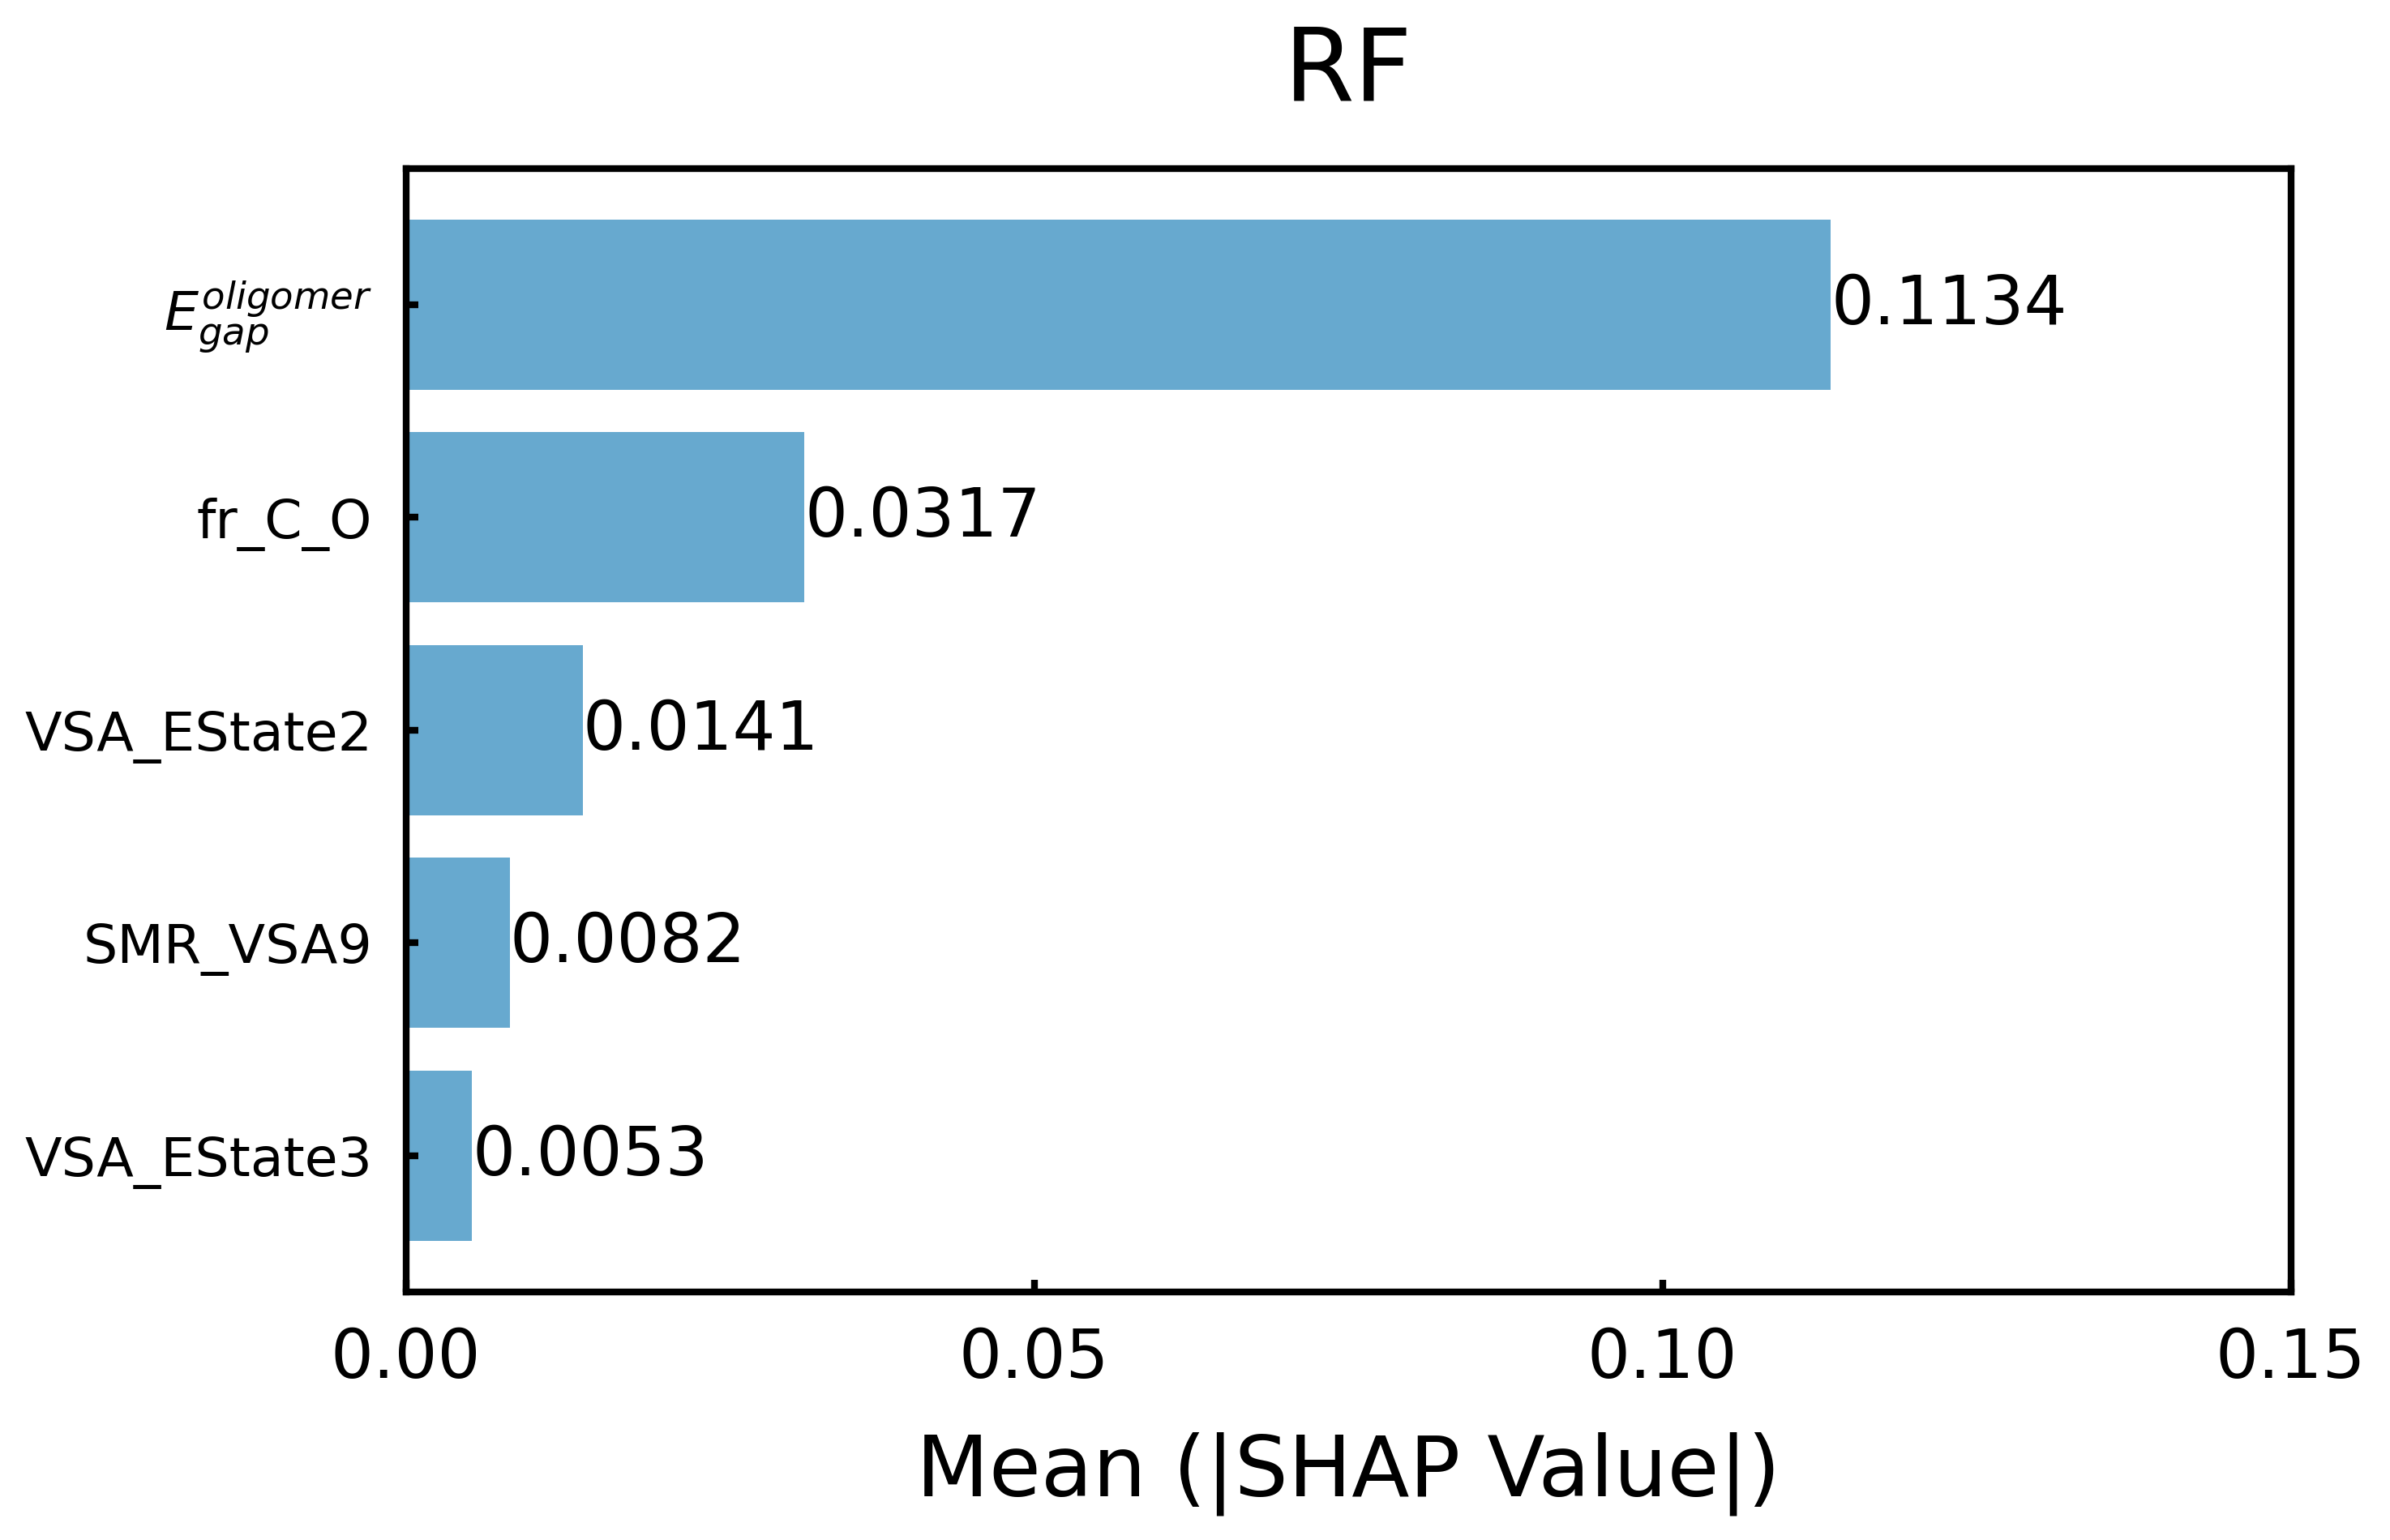

In [27]:
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #42
    model.fit(X_train, y_train)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # 计算特征重要性
    shap_importance = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame(list(zip(X.columns, shap_importance)), columns=['Feature', 'Importance'])
    feature_importance['Feature'] = feature_importance['Feature'].replace('HOMO-LUMO gap', '$E_{gap}^{oligomer}$')

    feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

    # 获取前5个最重要的特征
    top_5_features = feature_importance['Feature'].iloc[:5]
    top_5_indices = feature_importance.index[:5]

    # 过滤出前5个特征的SHAP值
    top_5_shap_values = shap_values[:, top_5_indices]
    
    shap_plot(top_5_features, feature_importance, name)

### 2. 10-fold cv plus 10-fold cv average

In [21]:
xfold=10
models = []
foldername = name+'-10fold-cv-plus-10fold-cv-average'

for fold_idx in range(xfold):
    for fold_idx_sub in range(xfold):
        model_filename = foldername + f'/model_fold_{fold_idx + 1}_subfold_{fold_idx_sub + 1}.pkl'
        model = joblib.load(model_filename)
        models.append(model)
        
len(models)

100

In [ ]:


print("Start predicting...")
shap_mean = []

for i in range(xfold):
    train_index = train_idx_list[i]
    test_index = test_idx_list[i]

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index] 

#     predictions = []

    for j in range(xfold):
        model = models[i*xfold+j]     

        y_pred = model.predict(X_test)
        
                
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        
        gap_shap_values = shap_values[:, -1]  
        all_shap_values = shap_values[:, :]
        percentage = (np.abs(gap_shap_values) / np.abs(all_shap_values).sum(axis=1)) * 100
        shap_mean.append(percentage.mean())

In [56]:
# 10fold-CV plus 10fold-CV average
foldername = 'xgb-10fold-cv-plus-10fold-cv-average'
os.makedirs(foldername, exist_ok=True)

# save index for train and test of each fold
train_idx_list = []
test_idx_list = []
print('Start training...')

for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_idx_list.append(train_index)
    test_idx_list.append(test_index)

    kf_sub = KFold(n_splits=xfold, shuffle=True, random_state=42)
    for fold_idx_sub, (train_index_sub, test_index_sub) in enumerate(kf_sub.split(X_train)):
        X_kf_train, X_kf_test = X_train.iloc[train_index_sub], X_train.iloc[test_index_sub]
        y_kf_train, y_kf_test = y_train.iloc[train_index_sub], y_train.iloc[test_index_sub]

        # 训练模型
        model.fit(X_kf_train, y_kf_train)

        # 保存模型
        model_filename = foldername + f'/model_fold_{fold_idx + 1}_subfold_{fold_idx_sub + 1}.pkl'
        joblib.dump(model, model_filename)



Start training...
Start predicting...


In [57]:
np.mean(shap_mean)

34.038217911716906

In [58]:
len(shap_mean)

100